In [1]:
import xarray_beam as xb

ds, _ = xb.open_zarr('gcs://gcp-public-data-arco-era5/ar/1959-2022-6h-1440x721.zarr')

In [3]:
temp = ds['2m_temperature']

In [8]:
import numpy as np
import pandas as pd

start_date = pd.to_datetime('2021-03-08')
end_date = pd.to_datetime('2021-03-09')
source_dataset = temp.sel(time=slice(start_date, end_date))

print(source_dataset)

lat_min, lat_max = (0, 60)
lon_min, lon_max = (90, 165)

  # 해당 범위에 속하는 위도와 경도의 인덱스 찾기
lat_indices = np.where((source_dataset.latitude >= lat_min) & (source_dataset.latitude <= lat_max))[0]
lon_indices = np.where((source_dataset.longitude >= lon_min) & (source_dataset.longitude <= lon_max))[0]

source_dataset = source_dataset.isel(latitude=lat_indices, longitude=lon_indices)

<xarray.DataArray '2m_temperature' (time: 5, latitude: 721, longitude: 1440)>
[5191200 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2021-03-08 ... 2021-03-09
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K


In [9]:
print(source_dataset)

<xarray.DataArray '2m_temperature' (time: 5, latitude: 241, longitude: 301)>
[362705 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 0.75 0.5 0.25 0.0
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 164.5 164.8 165.0
  * time       (time) datetime64[ns] 2021-03-08 ... 2021-03-09
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K


In [10]:
dataset = source_dataset.values

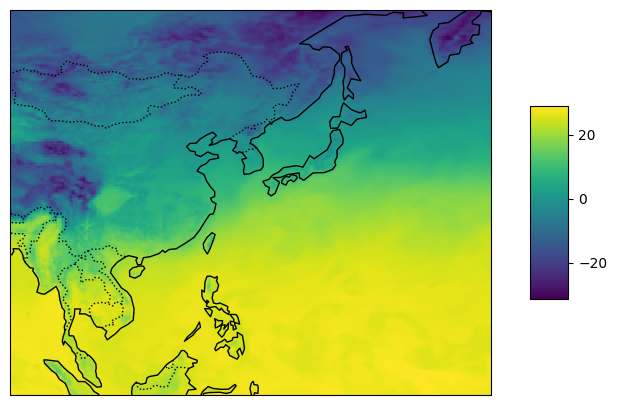

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 예제 NumPy 배열 생성
data = dataset[0][::-1, :]

data = data - 273.15

# 지도 생성 및 데이터 시각화
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 지도에 기본 레이어 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# NumPy 배열을 지도 위에 표시 (임의의 위경도 범위에 맞게 조정)
lons = np.linspace(lon_min, lon_max, data.shape[1])
lats = np.linspace(lat_min, lat_max, data.shape[0])
Lons, Lats = np.meshgrid(lons, lats)
mesh = ax.pcolormesh(Lons, Lats, data, transform=ccrs.PlateCarree())

plt.colorbar(mesh, ax=ax, shrink=0.5, aspect=5)

plt.show()